In [ ]:
from sklearn.decomposition import IncrementalPCA
import pandas as pd
import os
from tqdm import tqdm
from pathlib import Path

def fit_pca(embeddings_path="/embeddings/grasr-embedding/", name="cif2grasr"):
    """
    Iteratively fit PCA on all embeddings in the folder.

    Args:
    embeddings_path (str): path to the folder with embeddings
    name (str): base name of the embedding pkl file

    Returns:
    sklearn.decomposition.IncrementalPCA: fitted PCA model
    """
    ipca = IncrementalPCA(50)

    embeddings = os.listdir(embeddings_path)[:1000]
    embeddings = [file for file in embeddings if name in file]

    for emb in tqdm(embeddings, desc="Fitting PCA"):
        data = pd.read_pickle(os.path.join(embeddings_path, emb))
        data = list(value for value in data['embedding'].values)
        ipca.partial_fit(data)
    return ipca

def transform_embeddings(pca, embeddings_path="/embeddings/grasr-embedding/", name="cif2grasr", output_path="/embeddings/pca-grasr-embedding/"):
    """
    Transform embeddings with PCA and save them to the output folder.

    Args:
    pca (sklearn.decomposition.IncrementalPCA): fitted PCA model
    embeddings_path (str): path to the folder with embeddings
    name (str): base name of the embedding pkl file
    output_path (str): path to the output folder
    """
    os.makedirs(output_path, exist_ok=True)
    embeddings = os.listdir(embeddings_path)
    embeddings = [file for file in embeddings if name in file]

    for emb in tqdm(embeddings, desc="Transforming and saving embeddings"):
        unpickled_df = pd.read_pickle(os.path.join(embeddings_path, emb))
        raw_embeddings = list(value for value in unpickled_df['embedding'].values)
        embeddings_transformed = pca.transform(raw_embeddings)
        pca_embeddings = {}
        for protein, embedding in zip(unpickled_df['protein'].values, embeddings_transformed):
            pca_embeddings[protein] = embedding

        df = pd.DataFrame(list(pca_embeddings.items()), columns=["protein", "embedding"])
        df.to_pickle(os.path.join(output_path, "pca-" + emb))

ipca = fit_pca()
#transform_embeddings(ipca)

In [ ]:
from kubernetes import client, config

config.load_kube_config(config_file="kuba-cluster.yaml")
api_instance = client.BatchV1Api()


# list all jobs under namespace
api_response = api_instance.list_namespaced_job(namespace="fi-lmi-ns")
jobs = [job.metadata.name for job in api_response.items if job.metadata.name.startswith("granularity-30")]
print(len(jobs))
# delete jobs
for job in jobs:
    try:
        api_response = api_instance.delete_namespaced_job(
            name=job,
            namespace="fi-lmi-ns",
            body=client.V1DeleteOptions(
                propagation_policy='Foreground',
                grace_period_seconds=5))
    except Exception as e:
        print(e)

In [ ]:
# list all files in folder
import os
import glob
from multiprocessing import Pool
from time import sleep


files = glob.glob("/embeddings/3dzd-embedding/cif23dzd-result-*")
files = [file.split("-")[-1].split(".")[0] for file in files]

files2 = glob.glob("/embeddings/configs/*")
files2 = [file.split("-")[-1] for file in files2]
remaining_jobs = set(files2) - set(files)
len(list(remaining_jobs))

for job in remaining_jobs:
    sleep(1)
    os.system(f"python job_orchestrator.py -t job_templates/3dzd-job.yaml.jinja2 -i {job} -j 1 -m 100 -n fi-lmi-ns &")

In [2]:
from random import sample
import pandas as pd


proteins = {}
PROTEIN_INDEX = pd.read_csv("/embeddings/proteins-index.csv", sep="\t", header=None)

for i in range(25):
    protein_sample = PROTEIN_INDEX.sample(1)
    protein_sample = protein_sample[0].values[0].split(",")
    protein_sample = sample(protein_sample[1:], 1)
    print(f"https://search.foldseek.com/search?accession={protein_sample[0].split('-')[1]}&source=AlphaFoldDB")

https://search.foldseek.com/search?accession=F1B5A5&source=AlphaFoldDB
https://search.foldseek.com/search?accession=B3STG0&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A499JUY9&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A2S1HAU7&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A3G6IML3&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A220H7Z7&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A6C0R830&source=AlphaFoldDB
https://search.foldseek.com/search?accession=E0D9T2&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A346KW05&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A159E4H8&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A386III0&source=AlphaFoldDB
https://search.foldseek.com/search?accession=H2A023&source=AlphaFoldDB
https://search.foldseek.com/search?accession=A0A6M3AS98&source=AlphaFoldDB
https://search.foldseek.com/search?access

In [1]:
import pandas as pd
PROTEIN_INDEX = pd.read_csv("/embeddings/proteins-index.csv", sep="\t", header=None)

print(PROTEIN_INDEX.head(5))


                                                   0
0   proteome-tax_id-882679-0_v3.tar,AF-A0A0A7W7S9-F1
1  proteome-tax_id-882756-0_v3.tar,AF-G8Z514-F1,A...
2       proteome-tax_id-882753-0_v3.tar,AF-G8Z504-F1
3  proteome-tax_id-882762-0_v3.tar,AF-G8Z535-F1,A...
4  proteome-tax_id-882772-0_v3.tar,AF-G8Z538-F1,A...


In [3]:
import os

with open("/embeddings/proteins-index.csv", "r") as f:
    lines = f.readlines()
    # find number of ',' in file
    commas = [line.count(",") for line in lines]
print(sum(commas))


214684311


In [22]:
len(next(line for line in lines if "proteome-tax_id-2480626-0_v3.tar" in line).split(","))

8069

In [4]:
import os

lengths = []
files = [
    "proteome-tax_id-1916222-0_v3.tar",
    "proteome-tax_id-2292023-0_v3.tar",
    "proteome-tax_id-37931-1_v3.tar",
    "proteome-tax_id-1194971-0_v3.tar",
    "proteome-tax_id-999415-0_v3.tar"
]
for line in lines:
    if any(file in line.split(",")[0] for file in files):
        lengths.append(line.count(","))

print(sum(lengths))

9345


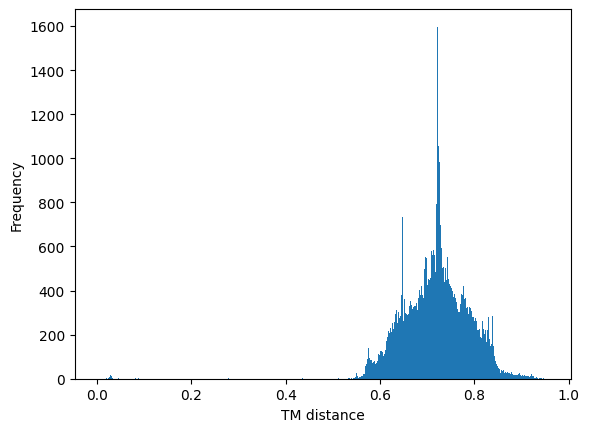

Total sample: 95663
Proteins with distance < 0.5: 95471
Proteins with distance < 0.1: 496


In [7]:
# plot histogram of values from starterpack/embeddings-computation/AF-A0A6F8FN44-F1-distances.json
import json
import matplotlib.pyplot as plt

with open("A0A2Z4N0P5_100k_distances.json", "r") as f:
    distances = json.load(f)

tm_distance = {k: v for k, v in distances.items()}
plt.hist([1-v for v in tm_distance.values()], bins=1000)
plt.xlabel("TM distance")
plt.ylabel("Frequency")
# plt.title("TM-distance distribution of A0A2Z4N0P5")
# save plt with DPI for print
plt.savefig("images/A0A2Z4N0P5_100k_distances.png", dpi=300)
plt.show()
print("Total sample:", len(tm_distance))
print("Proteins with distance < 0.5:", len([v for v in tm_distance.values() if v < 0.5]))
print("Proteins with distance < 0.1:", len([v for v in tm_distance.values() if v < 0.1]))

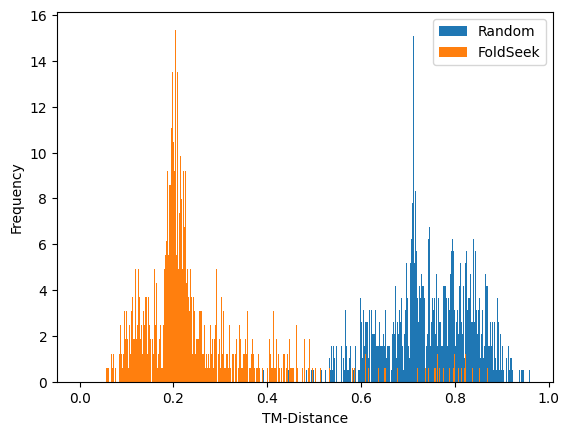

In [1]:
import json
import os
import matplotlib.pyplot as plt

files = os.listdir("results/")
files = [file for file in files if file.endswith("distances.json")]
files = [file.split("-")[1] for file in files]
protein = files[9]

with open(f"results/AF-{protein}-F1-distances.json", "r") as f:
    distances = json.load(f)

with open(f"foldseek-files/{protein}", "r") as f:
    f = f.read().split()
    foldseek_proteins = [w for w in f if w.startswith("AF-")]
    foldseek_proteins = [w.split("-model")[0].split("-")[1] for w in foldseek_proteins]

plt.hist([v for (k,v) in distances.items() if k not in foldseek_proteins], density=True, histtype='bar', stacked=True, bins=500)
plt.hist([v for (k,v) in distances.items() if k in foldseek_proteins], density=True, histtype='bar', stacked=True, bins=500)
plt.xlabel("TM-Distance")
plt.ylabel("Frequency")
plt.legend(["Random", "FoldSeek"])
# plt.title(f"TM distance distribution for {protein}")
plt.savefig("images/A0A3P1W0K9_subset.png", dpi=300)
plt.show()

In [1]:
import requests
import os
import json

candidate_proteins = os.listdir("foldseek-files/")
print("Proteins before filtering:", len(candidate_proteins))
filtered_proteins = []
for protein in candidate_proteins:
    with open(f"results/AF-{protein}-F1-distances.json") as file:
        json_file = json.load(file)
        if list(json_file.values())[600] < 0.5:
            filtered_proteins.append(protein)
candidate_proteins = filtered_proteins
print("Final sample size:", len(candidate_proteins))

results = []
for protein in candidate_proteins:
    response = requests.get(f"https://alphafold.ebi.ac.uk/api/uniprot/summary/{protein}.json")
    results.append(response.json())


Proteins before filtering: 109
Final sample size: 81


Mean: 220.23456790123456 , stdev 86.82894658784035
Shortest protein ('A4SGP8', 75) Longest protein ('K4JDQ0', 661)


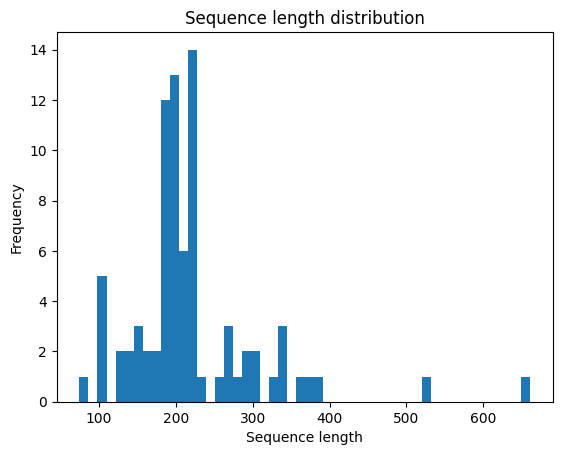

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# average sequence_length
sequence_lengths = [result["uniprot_entry"]["sequence_length"] for result in results]
print("Mean:", np.mean(sequence_lengths), ", stdev", np.std(sequence_lengths))

zipped_proteins = list(zip(candidate_proteins, sequence_lengths))
print("Shortest protein", min(zipped_proteins, key=lambda x: x[1]), "Longest protein", max(zipped_proteins, key=lambda x: x[1]))

plt.hist(sequence_lengths, bins=50)
plt.xlabel("Sequence length")
plt.ylabel("Frequency")
plt.title("Sequence length distribution")
plt.show()


In [3]:
import requests

uniprot_results = []

for protein in candidate_proteins:
    response = requests.get(f"https://rest.uniprot.org/uniprotkb/search?query=accession:{protein}")
    uniprot_results.append(response.json())

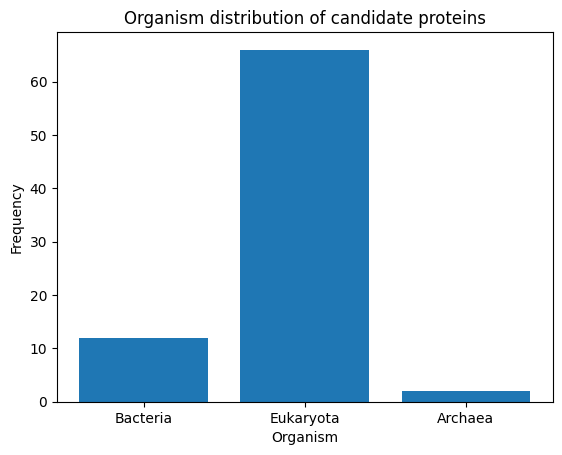

Eukaryota types: {'Viridiplantae', 'Sar', 'Fungi', 'Metazoa'}
Bacteria types: {'Chlorobiota', 'Bacillota', 'Cyanobacteriota', 'Actinomycetota', 'Fusobacteriota', 'Pseudomonadota'}


In [6]:
# plot barchart with occurences
from collections import Counter
import matplotlib.pyplot as plt


organisms = [result["results"][0]["organism"]["lineage"] for result in uniprot_results if "organism" in result["results"][0]]
primary_organism = [organism[0] for organism in organisms]

counter = Counter(primary_organism)
plt.bar(counter.keys(), counter.values())
plt.xlabel("Organism")
plt.ylabel("Frequency")
plt.title("Organism distribution of candidate proteins")
plt.show()

print("Eukaryota types:", set([organism[1] for organism in organisms if organism[0] == "Eukaryota"]))
print("Bacteria types:", set([organism[1] for organism in organisms if organism[0] == "Bacteria"]))

